<a href="https://colab.research.google.com/github/KarolMc/msc_dissertation/blob/main/tabnet_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import joblib

import pandas as pd
import numpy as np

# Import SVC from sklearn.svm and accuracy_score from sklearn.metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer

import random

random_seed = random.seed(42)

from sklearn.preprocessing import LabelEncoder

In [ ]:
import configparser
import numpy as np
import keras
import os
import pandas as pd
import shutil

In [ ]:
from keras import backend
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, concatenate, Conv2D, BatchNormalization, ReLU, MaxPooling2D, \
    Flatten, AlphaDropout
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score, \
    matthews_corrcoef

In [ ]:
import torch

In [ ]:
!pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 16.0 MB/s eta 0:00:00


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:

X_train = pd.read_csv('/notebooks/Data/multiselected_data/X_train_multiselected.csv', index_col=[0])
y_train = pd.read_csv('/notebooks/Data/y_train_SMOV.csv', index_col=[0])
X_test = pd.read_csv('/notebooks/Data/multiselected_data/X_test_multiselected.csv', index_col=[0])
y_test = pd.read_csv('/notebooks/Data/y_test.csv', index_col=[0])

train_features = X_train.columns


le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_test = le.fit_transform(y_test)

X_train_val, X_validation, y_train_val, y_validation = train_test_split(X_train, y_train, test_size=0.25)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train.shape

(75864, 68)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
#store data, all in numpy arrays
training_data = {'X_train':X_train_val,'y_train':y_train_val,
                'X_val': X_validation,'y_val':y_validation,
                'X_test': X_test,'y_test':y_test}

In [ ]:
tab1 = joblib.load('pretrained_tabnet270123.joblib')

In [ ]:
tab1.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

epoch 0  | loss: 0.76868 | train_logloss: 2.22625 | train_accuracy: 0.33395 | valid_logloss: 2.22293 | valid_accuracy: 0.33497 |  0:00:07s
epoch 1  | loss: 0.60616 | train_logloss: 1.79547 | train_accuracy: 0.49663 | valid_logloss: 1.79112 | valid_accuracy: 0.50232 |  0:00:13s
epoch 2  | loss: 0.51807 | train_logloss: 0.58348 | train_accuracy: 0.75052 | valid_logloss: 0.59539 | valid_accuracy: 0.75108 |  0:00:17s
epoch 3  | loss: 0.47871 | train_logloss: 0.4622  | train_accuracy: 0.79992 | valid_logloss: 0.47948 | valid_accuracy: 0.79379 |  0:00:22s
epoch 4  | loss: 0.4561  | train_logloss: 0.45021 | train_accuracy: 0.80994 | valid_logloss: 0.46891 | valid_accuracy: 0.8036  |  0:00:27s
epoch 5  | loss: 0.4422  | train_logloss: 0.42915 | train_accuracy: 0.81743 | valid_logloss: 0.44524 | valid_accuracy: 0.81056 |  0:00:32s
epoch 6  | loss: 0.43889 | train_logloss: 0.42722 | train_accuracy: 0.81811 | valid_logloss: 0.44872 | valid_accuracy: 0.80976 |  0:00:37s
epoch 7  | loss: 0.42979 | 

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
param_test1 = {'n_d'         : [32, 64, 128]}
scoring = ['balanced_accuracy', 'neg_log_loss']
Grid_tab1 = GridSearchCV(estimator=tab1, scoring = scoring, param_grid = param_test1, refit = 'balanced_accuracy', cv = 2, n_jobs=-1)
Grid_tab1.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','balanced_accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

In [ ]:
Grid_tab1.best_estimator_

In [ ]:
tab2 = TabNetClassifier(n_d=128, 
                        n_a=8, 
                        n_steps=3, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab2.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 0.82159 | train_logloss: 7.22172 | train_balanced_accuracy: 0.41101 | valid_logloss: 7.35841 | valid_balanced_accuracy: 0.40886 |  0:00:06s
epoch 1  | loss: 0.56652 | train_logloss: 3.00145 | train_balanced_accuracy: 0.4733  | valid_logloss: 3.0121  | valid_balanced_accuracy: 0.47254 |  0:00:13s
epoch 2  | loss: 0.51127 | train_logloss: 3.05997 | train_balanced_accuracy: 0.44838 | valid_logloss: 3.08009 | valid_balanced_accuracy: 0.45223 |  0:00:19s
epoch 3  | loss: 0.48255 | train_logloss: 2.10184 | train_balanced_accuracy: 0.4591  | valid_logloss: 2.10287 | valid_balanced_accuracy: 0.45709 |  0:00:24s
epoch 4  | loss: 0.46021 | train_logloss: 0.96239 | train_balanced_accuracy: 0.66012 | valid_logloss: 0.97722 | valid_balanced_accuracy: 0.65346 |  0:00:30s
epoch 5  | loss: 0.43554 | train_logloss: 0.55611 | train_balanced_accuracy: 0.76317 | valid_logloss: 0.57453 | valid_balanced_accuracy: 0.75245 |  0:00:36s
epoch 6  | loss: 0.41777 | train_logloss: 0.47188 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, recall_score, f1_score

In [ ]:
from sklearn.metrics import fbeta_score

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9074788913356343
BEST ACCURACY SCORE ON TEST SET : 0.6736462415401488
BEST f1_weighted SCORE ON VALIDATION SET : 0.905582177999895
BEST f1_weighted SCORE ON TEST SET : 0.7532278908306993
BEST fbeta SCORE ON VALIDATION SET : 0.905582177999895
BEST fbeta SCORE ON TEST SET : 0.7532278908306993


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


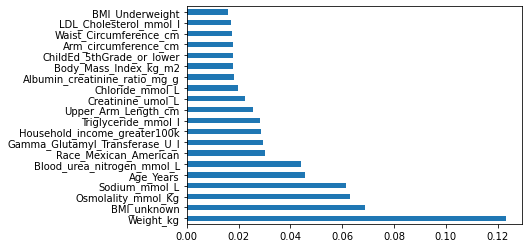

In [ ]:
# find and plot feature importance
y_pred = tab2.predict(training_data['X_test'].values)
tab2.feature_importances_
feat_importances = pd.Series(tab2.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab2.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab2.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


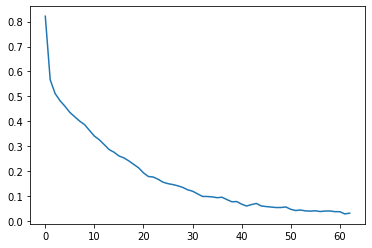

In [ ]:
# plot losses
plt.plot(tab2.history['loss'])




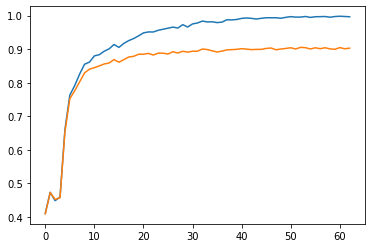

In [ ]:
# plot accuracy
plt.plot(tab2.history['train_balanced_accuracy'])
plt.plot(tab2.history['valid_balanced_accuracy'])


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

              precision    recall  f1-score   support

     class 1       0.89      0.83      0.86      8396
     class 2       0.49      0.60      0.54      2728
     class 3       0.64      0.60      0.62      1054

    accuracy                           0.76     12178
   macro avg       0.67      0.68      0.67     12178
weighted avg       0.78      0.76      0.77     12178



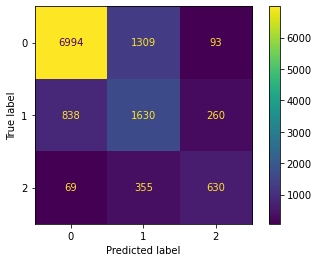

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab2.classes_).plot()
plt.show()


In [ ]:
param_test2 = {'n_steps'         : [2, 4, 7, 9]}
scoring = ['balanced_accuracy', 'neg_log_loss']
Grid_tab2 = GridSearchCV(estimator=tab2, scoring = scoring, param_grid = param_test2, refit = 'balanced_accuracy', cv = 2, n_jobs=-1)
Grid_tab2.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','balanced_accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.75646 | train_logloss: 5.87025 | train_balanced_accuracy: 0.17657 | valid_logloss: 5.85823 | valid_balanced_accuracy: 0.17992 |  0:00:05s
epoch 1  | loss: 0.51774 | train_logloss: 2.0794  | train_balanced_accuracy: 0.52521 | valid_logloss: 2.06386 | valid_balanced_accuracy: 0.52501 |  0:00:10s
epoch 2  | loss: 0.47506 | train_logloss: 1.80865 | train_balanced_accuracy: 0.4676  | valid_logloss: 1.80955 | valid_balanced_accuracy: 0.47014 |  0:00:15s
epoch 3  | loss: 0.456   | train_logloss: 1.0065  | train_balanced_accuracy: 0.55305 | valid_logloss: 1.0218  | valid_balanced_accuracy: 0.55307 |  0:00:20s
epoch 4  | loss: 0.43678 | train_logloss: 0.95553 | train_balanced_accuracy: 0.57137 | valid_logloss: 0.96695 | valid_balanced_accuracy: 0.57214 |  0:00:25s
epoch 5  | loss: 0.40753 | train_logloss: 0.50889 | train_balanced_accuracy: 0.78272 | valid_logloss: 0.53923 | valid_balanced_accuracy: 0.77222 |  0:00:30s
epoch 6  | loss: 0.37739 | train_logloss: 0.45485 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 156| loss: 0.00474 | train_logloss: 0.54633 | train_balanced_accuracy: 0.93508 | valid_logloss: 1.05127 | valid_balanced_accuracy: 0.87589 |  0:13:35s
epoch 157| loss: 0.00447 | train_logloss: 0.56398 | train_balanced_accuracy: 0.93532 | valid_logloss: 1.08458 | valid_balanced_accuracy: 0.87483 |  0:13:41s
epoch 158| loss: 0.00487 | train_logloss: 0.55388 | train_balanced_accuracy: 0.93534 | valid_logloss: 1.05954 | valid_balanced_accuracy: 0.87499 |  0:13:46s
epoch 159| loss: 0.00546 | train_logloss: 0.55723 | train_balanced_accuracy: 0.93532 | valid_logloss: 1.06654 | valid_balanced_accuracy: 0.87345 |  0:13:51s
epoch 160| loss: 0.00545 | train_logloss: 0.56154 | train_balanced_accuracy: 0.93537 | valid_logloss: 1.07356 | valid_balanced_accuracy: 0.87595 |  0:13:56s
epoch 161| loss: 0.00428 | train_logloss: 0.56961 | train_balanced_accuracy: 0.93613 | valid_logloss: 1.0985  | valid_balanced_accuracy: 0.8762  |  0:14:01s
epoch 162| loss: 0.00476 | train_logloss: 0.56291 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 52 | loss: 0.05439 | train_logloss: 0.49331 | train_balanced_accuracy: 0.8885  | valid_logloss: 0.8196  | valid_balanced_accuracy: 0.83474 |  0:10:14s
epoch 53 | loss: 0.06006 | train_logloss: 0.61241 | train_balanced_accuracy: 0.87196 | valid_logloss: 0.9672  | valid_balanced_accuracy: 0.82408 |  0:10:25s
epoch 54 | loss: 0.05602 | train_logloss: 0.3281  | train_balanced_accuracy: 0.93047 | valid_logloss: 0.61349 | valid_balanced_accuracy: 0.87005 |  0:10:37s
epoch 55 | loss: 0.0496  | train_logloss: 0.5522  | train_balanced_accuracy: 0.87589 | valid_logloss: 0.88879 | valid_balanced_accuracy: 0.82399 |  0:10:49s
epoch 56 | loss: 0.05105 | train_logloss: 0.5318  | train_balanced_accuracy: 0.88704 | valid_logloss: 0.89146 | valid_balanced_accuracy: 0.83129 |  0:11:01s
epoch 57 | loss: 0.05105 | train_logloss: 0.54176 | train_balanced_accuracy: 0.8842  | valid_logloss: 0.87839 | valid_balanced_accuracy: 0.82928 |  0:11:12s
epoch 58 | loss: 0.04778 | train_logloss: 0.50866 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.0025  | train_logloss: 0.63671 | train_balanced_accuracy: 0.93571 | valid_logloss: 1.21438 | valid_balanced_accuracy: 0.87827 |  0:18:05s
epoch 209| loss: 0.00385 | train_logloss: 0.63327 | train_balanced_accuracy: 0.93595 | valid_logloss: 1.20743 | valid_balanced_accuracy: 0.87731 |  0:18:11s
epoch 210| loss: 0.00303 | train_logloss: 0.63445 | train_balanced_accuracy: 0.93597 | valid_logloss: 1.22117 | valid_balanced_accuracy: 0.87741 |  0:18:16s
epoch 211| loss: 0.00221 | train_logloss: 0.64602 | train_balanced_accuracy: 0.93634 | valid_logloss: 1.24296 | valid_balanced_accuracy: 0.8782  |  0:18:21s
epoch 212| loss: 0.00247 | train_logloss: 0.64954 | train_balanced_accuracy: 0.93641 | valid_logloss: 1.23981 | valid_balanced_accuracy: 0.878   |  0:18:26s
epoch 213| loss: 0.00331 | train_logloss: 0.63803 | train_balanced_accuracy: 0.93574 | valid_logloss: 1.22393 | valid_balanced_accuracy: 0.87731 |  0:18:31s
epoch 214| loss: 0.00268 | train_logloss: 0.63619 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 23 | loss: 0.38455 | train_logloss: 0.40703 | train_balanced_accuracy: 0.83038 | valid_logloss: 0.44267 | valid_balanced_accuracy: 0.81246 |  0:05:39s
epoch 24 | loss: 0.37336 | train_logloss: 0.3867  | train_balanced_accuracy: 0.84109 | valid_logloss: 0.42062 | valid_balanced_accuracy: 0.82545 |  0:05:52s
epoch 25 | loss: 0.36873 | train_logloss: 0.38231 | train_balanced_accuracy: 0.84605 | valid_logloss: 0.42148 | valid_balanced_accuracy: 0.82549 |  0:06:06s
epoch 26 | loss: 0.35634 | train_logloss: 0.38293 | train_balanced_accuracy: 0.84273 | valid_logloss: 0.42276 | valid_balanced_accuracy: 0.82555 |  0:06:20s
epoch 27 | loss: 0.3377  | train_logloss: 0.42224 | train_balanced_accuracy: 0.82698 | valid_logloss: 0.47414 | valid_balanced_accuracy: 0.81    |  0:06:33s
epoch 28 | loss: 0.33643 | train_logloss: 0.40851 | train_balanced_accuracy: 0.8303  | valid_logloss: 0.46445 | valid_balanced_accuracy: 0.80974 |  0:06:46s
epoch 29 | loss: 0.31856 | train_logloss: 0.39011 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 82 | loss: 0.03652 | train_logloss: 0.40878 | train_balanced_accuracy: 0.91999 | valid_logloss: 0.79282 | valid_balanced_accuracy: 0.85319 |  0:18:04s
epoch 83 | loss: 0.03523 | train_logloss: 0.38694 | train_balanced_accuracy: 0.92803 | valid_logloss: 0.76456 | valid_balanced_accuracy: 0.86054 |  0:18:16s
epoch 84 | loss: 0.03704 | train_logloss: 0.40317 | train_balanced_accuracy: 0.92606 | valid_logloss: 0.78451 | valid_balanced_accuracy: 0.85924 |  0:18:27s
epoch 85 | loss: 0.0362  | train_logloss: 0.39698 | train_balanced_accuracy: 0.92697 | valid_logloss: 0.77827 | valid_balanced_accuracy: 0.85813 |  0:18:39s
epoch 86 | loss: 0.03714 | train_logloss: 0.45449 | train_balanced_accuracy: 0.91809 | valid_logloss: 0.86166 | valid_balanced_accuracy: 0.85092 |  0:18:51s
epoch 87 | loss: 0.03607 | train_logloss: 0.45422 | train_balanced_accuracy: 0.91528 | valid_logloss: 0.8566  | valid_balanced_accuracy: 0.85408 |  0:19:03s
epoch 88 | loss: 0.03105 | train_logloss: 0.4304  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 259 with best_epoch = 209 and best_valid_balanced_accuracy = 0.8759
epoch 134| loss: 0.012   | train_logloss: 0.49495 | train_balanced_accuracy: 0.93141 | valid_logloss: 1.01105 | valid_balanced_accuracy: 0.86433 |  0:28:15s
epoch 135| loss: 0.0086  | train_logloss: 0.50947 | train_balanced_accuracy: 0.92962 | valid_logloss: 1.04359 | valid_balanced_accuracy: 0.85883 |  0:28:26s
epoch 136| loss: 0.00802 | train_logloss: 0.55718 | train_balanced_accuracy: 0.92753 | valid_logloss: 1.12669 | valid_balanced_accuracy: 0.86041 |  0:28:37s
epoch 137| loss: 0.01092 | train_logloss: 0.52694 | train_balanced_accuracy: 0.92791 | valid_logloss: 1.07559 | valid_balanced_accuracy: 0.85872 |  0:28:48s
epoch 138| loss: 0.00854 | train_logloss: 0.59298 | train_balanced_accuracy: 0.9215  | valid_logloss: 1.17655 | valid_balanced_accuracy: 0.85438 |  0:29:00s
epoch 139| loss: 0.00944 | train_logloss: 0.47392 | train_balanced_accuracy: 0.93599 | valid_logloss: 0.982   | v

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.09471 | train_logloss: 2.88215 | train_balanced_accuracy: 0.44408 | valid_logloss: 2.9046  | valid_balanced_accuracy: 0.44241 |  0:00:13s
epoch 1  | loss: 0.62033 | train_logloss: 1.304   | train_balanced_accuracy: 0.57755 | valid_logloss: 1.32062 | valid_balanced_accuracy: 0.57422 |  0:00:28s
epoch 2  | loss: 0.53662 | train_logloss: 0.70411 | train_balanced_accuracy: 0.67538 | valid_logloss: 0.71002 | valid_balanced_accuracy: 0.67343 |  0:00:42s
epoch 3  | loss: 0.4791  | train_logloss: 0.60134 | train_balanced_accuracy: 0.7385  | valid_logloss: 0.61869 | valid_balanced_accuracy: 0.73466 |  0:00:56s
epoch 4  | loss: 0.44548 | train_logloss: 0.5406  | train_balanced_accuracy: 0.76865 | valid_logloss: 0.55989 | valid_balanced_accuracy: 0.76318 |  0:01:09s
epoch 5  | loss: 0.44238 | train_logloss: 0.45568 | train_balanced_accuracy: 0.80304 | valid_logloss: 0.47935 | valid_balanced_accuracy: 0.79353 |  0:01:22s
epoch 6  | loss: 0.42449 | train_logloss: 0.45191 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=2,
             estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], input_dim=68, mask_type='entmax', n_d=128, optimizer_params={'lr': 0.02}, output_dim=3, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.9, 'step_size': 10}, seed=42),
             n_jobs=-1, param_grid={'n_steps': [2, 4, 7, 9]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'neg_log_loss'])

In [ ]:
Grid_tab2.best_estimator_

TabNetClassifier(n_d=128, n_a=8, n_steps=7, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='entmax', input_dim=68, output_dim=3, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [ ]:
tab3 = TabNetClassifier(n_d=128, 
                        n_a=8, 
                        n_steps=7, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab3.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 1.35578 | train_logloss: 8.01188 | train_balanced_accuracy: 0.36811 | valid_logloss: 7.97106 | valid_balanced_accuracy: 0.36983 |  0:00:10s
epoch 1  | loss: 0.76416 | train_logloss: 15.92755| train_balanced_accuracy: 0.3389  | valid_logloss: 15.81568| valid_balanced_accuracy: 0.3391  |  0:00:21s
epoch 2  | loss: 0.64544 | train_logloss: 5.40266 | train_balanced_accuracy: 0.34102 | valid_logloss: 5.36153 | valid_balanced_accuracy: 0.34265 |  0:00:31s
epoch 3  | loss: 0.62474 | train_logloss: 1.78408 | train_balanced_accuracy: 0.40653 | valid_logloss: 1.77911 | valid_balanced_accuracy: 0.41469 |  0:00:42s
epoch 4  | loss: 0.59716 | train_logloss: 0.64874 | train_balanced_accuracy: 0.72803 | valid_logloss: 0.65488 | valid_balanced_accuracy: 0.72873 |  0:00:53s
epoch 5  | loss: 0.57083 | train_logloss: 0.82945 | train_balanced_accuracy: 0.63636 | valid_logloss: 0.83513 | valid_balanced_accuracy: 0.63662 |  0:01:04s
epoch 6  | loss: 0.54427 | train_logloss: 0.57511 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.8986099971630374
BEST ACCURACY SCORE ON TEST SET : 0.6833015097480725
BEST f1_weighted SCORE ON VALIDATION SET : 0.8984236199669965
BEST f1_weighted SCORE ON TEST SET : 0.7636999922517456
BEST fbeta SCORE ON VALIDATION SET : 0.8984236199669965
BEST fbeta SCORE ON TEST SET : 0.7636999922517456


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


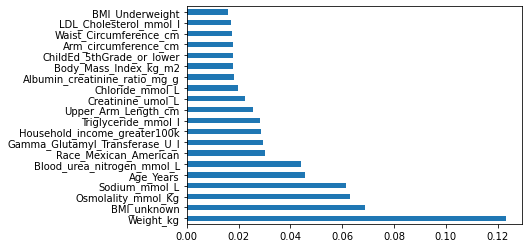

In [ ]:
# find and plot feature importance
y_pred = tab3.predict(training_data['X_test'].values)
tab2.feature_importances_
feat_importances = pd.Series(tab2.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab3.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab3.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")

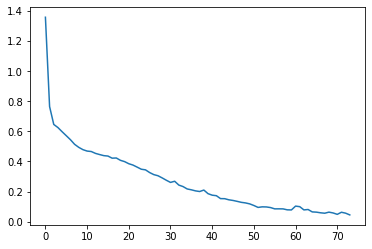

In [ ]:
# plot losses
plt.plot(tab3.history['loss'])


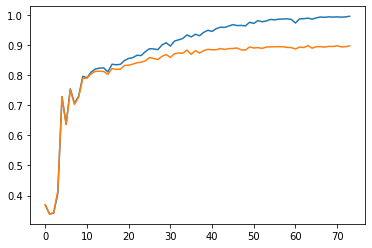

In [ ]:
# plot accuracy
plt.plot(tab3.history['train_balanced_accuracy'])
plt.plot(tab3.history['valid_balanced_accuracy'])


              precision    recall  f1-score   support

     class 1       0.89      0.84      0.86      8396
     class 2       0.51      0.59      0.55      2728
     class 3       0.65      0.63      0.64      1054

    accuracy                           0.77     12178
   macro avg       0.68      0.69      0.69     12178
weighted avg       0.78      0.77      0.77     12178



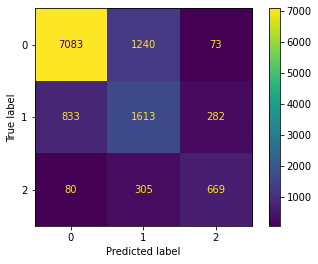

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab3.classes_).plot()
plt.show()


In [ ]:
param_test3 = {'n_shared'         : [0, 1, 2, 3, 4]}
scoring = ['balanced_accuracy', 'neg_log_loss']
Grid_tab3 = GridSearchCV(estimator=tab3, scoring = scoring, param_grid = param_test3, refit = 'balanced_accuracy', cv = 2, n_jobs=-1)
Grid_tab3.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','balanced_accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

epoch 0  | loss: 1.33145 | train_logloss: 11.39032| train_balanced_accuracy: 0.30811 | valid_logloss: 11.36229| valid_balanced_accuracy: 0.31141 |  0:00:09s
epoch 1  | loss: 0.78022 | train_logloss: 3.18336 | train_balanced_accuracy: 0.42048 | valid_logloss: 3.13757 | valid_balanced_accuracy: 0.42114 |  0:00:16s
epoch 2  | loss: 0.69248 | train_logloss: 1.92177 | train_balanced_accuracy: 0.51768 | valid_logloss: 1.94089 | valid_balanced_accuracy: 0.51782 |  0:00:25s
epoch 3  | loss: 0.6543  | train_logloss: 1.21005 | train_balanced_accuracy: 0.49679 | valid_logloss: 1.21031 | valid_balanced_accuracy: 0.49896 |  0:00:33s
epoch 4  | loss: 0.61957 | train_logloss: 0.97336 | train_balanced_accuracy: 0.58401 | valid_logloss: 0.97052 | valid_balanced_accuracy: 0.58007 |  0:00:42s
epoch 5  | loss: 0.5664  | train_logloss: 0.66508 | train_balanced_accuracy: 0.68906 | valid_logloss: 0.67671 | valid_balanced_accuracy: 0.67857 |  0:00:50s
epoch 6  | loss: 0.5351  | train_logloss: 0.57511 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 52 | loss: 0.0863  | train_logloss: 0.35386 | train_balanced_accuracy: 0.91224 | valid_logloss: 0.64463 | valid_balanced_accuracy: 0.8483  |  0:09:02s
epoch 53 | loss: 0.08204 | train_logloss: 0.37398 | train_balanced_accuracy: 0.91133 | valid_logloss: 0.67756 | valid_balanced_accuracy: 0.85082 |  0:09:13s
epoch 54 | loss: 0.08915 | train_logloss: 0.34448 | train_balanced_accuracy: 0.91543 | valid_logloss: 0.63846 | valid_balanced_accuracy: 0.84832 |  0:09:23s
epoch 55 | loss: 0.08034 | train_logloss: 0.33957 | train_balanced_accuracy: 0.92022 | valid_logloss: 0.63081 | valid_balanced_accuracy: 0.85289 |  0:09:33s
epoch 56 | loss: 0.0686  | train_logloss: 0.36856 | train_balanced_accuracy: 0.91666 | valid_logloss: 0.68889 | valid_balanced_accuracy: 0.85053 |  0:09:43s
epoch 57 | loss: 0.06838 | train_logloss: 0.34738 | train_balanced_accuracy: 0.92295 | valid_logloss: 0.66444 | valid_balanced_accuracy: 0.85698 |  0:09:53s
epoch 58 | loss: 0.06212 | train_logloss: 0.39789 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 104| loss: 0.03954 | train_logloss: 0.4563  | train_balanced_accuracy: 0.92529 | valid_logloss: 0.90231 | valid_balanced_accuracy: 0.85227 |  0:14:22s
epoch 105| loss: 0.03824 | train_logloss: 0.47373 | train_balanced_accuracy: 0.92397 | valid_logloss: 0.92957 | valid_balanced_accuracy: 0.8539  |  0:14:30s
epoch 106| loss: 0.03779 | train_logloss: 0.44993 | train_balanced_accuracy: 0.92667 | valid_logloss: 0.88862 | valid_balanced_accuracy: 0.85461 |  0:14:38s
epoch 107| loss: 0.04283 | train_logloss: 0.44834 | train_balanced_accuracy: 0.92497 | valid_logloss: 0.89264 | valid_balanced_accuracy: 0.85437 |  0:14:46s
epoch 108| loss: 0.04185 | train_logloss: 0.44906 | train_balanced_accuracy: 0.92646 | valid_logloss: 0.89616 | valid_balanced_accuracy: 0.85451 |  0:14:54s
epoch 109| loss: 0.03708 | train_logloss: 0.45793 | train_balanced_accuracy: 0.92628 | valid_logloss: 0.90599 | valid_balanced_accuracy: 0.85493 |  0:15:02s
epoch 110| loss: 0.03626 | train_logloss: 0.44553 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 156| loss: 0.00803 | train_logloss: 0.57778 | train_balanced_accuracy: 0.93137 | valid_logloss: 1.16312 | valid_balanced_accuracy: 0.86161 |  0:26:31s
epoch 157| loss: 0.00855 | train_logloss: 0.58005 | train_balanced_accuracy: 0.93207 | valid_logloss: 1.16436 | valid_balanced_accuracy: 0.8624  |  0:26:42s
epoch 158| loss: 0.00641 | train_logloss: 0.57229 | train_balanced_accuracy: 0.93212 | valid_logloss: 1.14911 | valid_balanced_accuracy: 0.86572 |  0:26:52s
epoch 159| loss: 0.00696 | train_logloss: 0.58795 | train_balanced_accuracy: 0.93266 | valid_logloss: 1.18204 | valid_balanced_accuracy: 0.8661  |  0:27:02s
epoch 160| loss: 0.00852 | train_logloss: 0.57725 | train_balanced_accuracy: 0.93305 | valid_logloss: 1.16071 | valid_balanced_accuracy: 0.86451 |  0:27:12s
epoch 161| loss: 0.00533 | train_logloss: 0.60064 | train_balanced_accuracy: 0.93247 | valid_logloss: 1.19274 | valid_balanced_accuracy: 0.86398 |  0:27:22s
epoch 162| loss: 0.00501 | train_logloss: 0.59945 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 156| loss: 0.00397 | train_logloss: 0.55507 | train_balanced_accuracy: 0.93578 | valid_logloss: 1.09771 | valid_balanced_accuracy: 0.86947 |  0:29:58s
epoch 157| loss: 0.00763 | train_logloss: 0.56408 | train_balanced_accuracy: 0.93353 | valid_logloss: 1.10718 | valid_balanced_accuracy: 0.86904 |  0:30:10s
epoch 158| loss: 0.00675 | train_logloss: 0.58292 | train_balanced_accuracy: 0.93406 | valid_logloss: 1.14957 | valid_balanced_accuracy: 0.86882 |  0:30:21s
epoch 159| loss: 0.00625 | train_logloss: 0.53518 | train_balanced_accuracy: 0.9359  | valid_logloss: 1.06588 | valid_balanced_accuracy: 0.87152 |  0:30:33s
epoch 160| loss: 0.00461 | train_logloss: 0.56345 | train_balanced_accuracy: 0.93446 | valid_logloss: 1.10736 | valid_balanced_accuracy: 0.87063 |  0:30:44s
epoch 161| loss: 0.00604 | train_logloss: 0.54587 | train_balanced_accuracy: 0.93513 | valid_logloss: 1.07288 | valid_balanced_accuracy: 0.86967 |  0:30:56s
epoch 162| loss: 0.00518 | train_logloss: 0.55154 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 28 | loss: 0.23235 | train_logloss: 0.32165 | train_balanced_accuracy: 0.88227 | valid_logloss: 0.44482 | valid_balanced_accuracy: 0.8466  |  0:06:11s
epoch 29 | loss: 0.2203  | train_logloss: 0.32412 | train_balanced_accuracy: 0.88315 | valid_logloss: 0.45279 | valid_balanced_accuracy: 0.84696 |  0:06:24s
epoch 30 | loss: 0.20265 | train_logloss: 0.31259 | train_balanced_accuracy: 0.88654 | valid_logloss: 0.44238 | valid_balanced_accuracy: 0.84536 |  0:06:36s
epoch 31 | loss: 0.19586 | train_logloss: 0.33827 | train_balanced_accuracy: 0.88456 | valid_logloss: 0.48002 | valid_balanced_accuracy: 0.84446 |  0:06:49s
epoch 32 | loss: 0.17865 | train_logloss: 0.36826 | train_balanced_accuracy: 0.8762  | valid_logloss: 0.54262 | valid_balanced_accuracy: 0.83362 |  0:07:02s
epoch 33 | loss: 0.16742 | train_logloss: 0.30657 | train_balanced_accuracy: 0.89938 | valid_logloss: 0.47978 | valid_balanced_accuracy: 0.85197 |  0:07:14s
epoch 34 | loss: 0.16745 | train_logloss: 0.28778 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.00379 | train_logloss: 0.70204 | train_balanced_accuracy: 0.92944 | valid_logloss: 1.37178 | valid_balanced_accuracy: 0.86474 |  0:35:28s
epoch 209| loss: 0.00405 | train_logloss: 0.71231 | train_balanced_accuracy: 0.92886 | valid_logloss: 1.38768 | valid_balanced_accuracy: 0.8622  |  0:35:39s
epoch 210| loss: 0.00336 | train_logloss: 0.70346 | train_balanced_accuracy: 0.93028 | valid_logloss: 1.37503 | valid_balanced_accuracy: 0.86369 |  0:35:49s
epoch 211| loss: 0.00333 | train_logloss: 0.6649  | train_balanced_accuracy: 0.93244 | valid_logloss: 1.29145 | valid_balanced_accuracy: 0.86751 |  0:35:59s
epoch 212| loss: 0.00376 | train_logloss: 0.68655 | train_balanced_accuracy: 0.93167 | valid_logloss: 1.34017 | valid_balanced_accuracy: 0.86702 |  0:36:10s
epoch 213| loss: 0.00288 | train_logloss: 0.68759 | train_balanced_accuracy: 0.93188 | valid_logloss: 1.3367  | valid_balanced_accuracy: 0.86638 |  0:36:20s
epoch 214| loss: 0.00289 | train_logloss: 0.68949 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 80 | loss: 0.02933 | train_logloss: 0.40859 | train_balanced_accuracy: 0.93094 | valid_logloss: 0.80378 | valid_balanced_accuracy: 0.86793 |  0:17:16s
epoch 81 | loss: 0.03146 | train_logloss: 0.39616 | train_balanced_accuracy: 0.9323  | valid_logloss: 0.79379 | valid_balanced_accuracy: 0.86779 |  0:17:28s
epoch 82 | loss: 0.02125 | train_logloss: 0.41895 | train_balanced_accuracy: 0.93334 | valid_logloss: 0.8409  | valid_balanced_accuracy: 0.86592 |  0:17:41s
epoch 83 | loss: 0.01796 | train_logloss: 0.43849 | train_balanced_accuracy: 0.93413 | valid_logloss: 0.8685  | valid_balanced_accuracy: 0.86935 |  0:17:53s
epoch 84 | loss: 0.021   | train_logloss: 0.41414 | train_balanced_accuracy: 0.9346  | valid_logloss: 0.83115 | valid_balanced_accuracy: 0.8711  |  0:18:06s
epoch 85 | loss: 0.01821 | train_logloss: 0.42003 | train_balanced_accuracy: 0.93338 | valid_logloss: 0.84062 | valid_balanced_accuracy: 0.86763 |  0:18:18s
epoch 86 | loss: 0.02537 | train_logloss: 0.40613 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 42 | loss: 0.26686 | train_logloss: 0.43005 | train_balanced_accuracy: 0.82812 | valid_logloss: 0.51844 | valid_balanced_accuracy: 0.80015 |  0:09:56s
epoch 43 | loss: 0.25075 | train_logloss: 0.49482 | train_balanced_accuracy: 0.81927 | valid_logloss: 0.60073 | valid_balanced_accuracy: 0.79152 |  0:10:08s
epoch 44 | loss: 0.235   | train_logloss: 0.53009 | train_balanced_accuracy: 0.80915 | valid_logloss: 0.65719 | valid_balanced_accuracy: 0.77953 |  0:10:21s
epoch 45 | loss: 0.23002 | train_logloss: 0.46119 | train_balanced_accuracy: 0.82743 | valid_logloss: 0.57289 | valid_balanced_accuracy: 0.79636 |  0:10:34s
epoch 46 | loss: 0.21954 | train_logloss: 0.50241 | train_balanced_accuracy: 0.82864 | valid_logloss: 0.65205 | valid_balanced_accuracy: 0.79542 |  0:10:47s
epoch 47 | loss: 0.21647 | train_logloss: 0.47434 | train_balanced_accuracy: 0.84027 | valid_logloss: 0.61305 | valid_balanced_accuracy: 0.80655 |  0:11:00s
epoch 48 | loss: 0.2254  | train_logloss: 0.51686 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 158| loss: 0.00755 | train_logloss: 0.84716 | train_balanced_accuracy: 0.8691  | valid_logloss: 1.50299 | valid_balanced_accuracy: 0.81077 |  0:33:33s
epoch 159| loss: 0.00626 | train_logloss: 0.72664 | train_balanced_accuracy: 0.90856 | valid_logloss: 1.34916 | valid_balanced_accuracy: 0.85002 |  0:33:44s
epoch 160| loss: 0.00606 | train_logloss: 0.70417 | train_balanced_accuracy: 0.91393 | valid_logloss: 1.33492 | valid_balanced_accuracy: 0.85342 |  0:33:55s
epoch 161| loss: 0.00502 | train_logloss: 0.72989 | train_balanced_accuracy: 0.9097  | valid_logloss: 1.36474 | valid_balanced_accuracy: 0.8513  |  0:34:07s
epoch 162| loss: 0.00664 | train_logloss: 0.86184 | train_balanced_accuracy: 0.89529 | valid_logloss: 1.55697 | valid_balanced_accuracy: 0.83797 |  0:34:19s
epoch 163| loss: 0.00565 | train_logloss: 0.63045 | train_balanced_accuracy: 0.92323 | valid_logloss: 1.22152 | valid_balanced_accuracy: 0.86213 |  0:34:31s
epoch 164| loss: 0.00571 | train_logloss: 0.87569 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=2,
             estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], input_dim=68, mask_type='entmax', n_d=128, n_steps=7, optimizer_params={'lr': 0.02}, output_dim=3, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.9, 'step_size': 10}, seed=42),
             n_jobs=-1, param_grid={'n_shared': [0, 1, 2, 3, 4]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'neg_log_loss'])

In [ ]:
Grid_tab3.best_estimator_

TabNetClassifier(n_d=128, n_a=8, n_steps=7, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='entmax', input_dim=68, output_dim=3, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [ ]:
tab4 = TabNetClassifier(n_d=128, 
                        n_a=8, 
                        n_steps=7, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                         lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab4.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 1.36018 | train_logloss: 6.64583 | train_balanced_accuracy: 0.35578 | valid_logloss: 6.5364  | valid_balanced_accuracy: 0.35447 |  0:00:05s
epoch 1  | loss: 0.72488 | train_logloss: 4.77606 | train_balanced_accuracy: 0.38095 | valid_logloss: 4.79091 | valid_balanced_accuracy: 0.37702 |  0:00:10s
epoch 2  | loss: 0.65684 | train_logloss: 3.4324  | train_balanced_accuracy: 0.4218  | valid_logloss: 3.41665 | valid_balanced_accuracy: 0.42262 |  0:00:15s
epoch 3  | loss: 0.60142 | train_logloss: 1.3486  | train_balanced_accuracy: 0.54968 | valid_logloss: 1.32498 | valid_balanced_accuracy: 0.55548 |  0:00:20s
epoch 4  | loss: 0.57246 | train_logloss: 1.28257 | train_balanced_accuracy: 0.50525 | valid_logloss: 1.27974 | valid_balanced_accuracy: 0.50949 |  0:00:25s
epoch 5  | loss: 0.5404  | train_logloss: 0.70354 | train_balanced_accuracy: 0.6651  | valid_logloss: 0.70472 | valid_balanced_accuracy: 0.66209 |  0:00:30s
epoch 6  | loss: 0.50428 | train_logloss: 0.5269  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.8986099971630374
BEST ACCURACY SCORE ON TEST SET : 0.6833015097480725
BEST f1_weighted SCORE ON VALIDATION SET : 0.8984236199669965
BEST f1_weighted SCORE ON TEST SET : 0.7636999922517456
BEST fbeta SCORE ON VALIDATION SET : 0.8984236199669965
BEST fbeta SCORE ON TEST SET : 0.7636999922517456


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


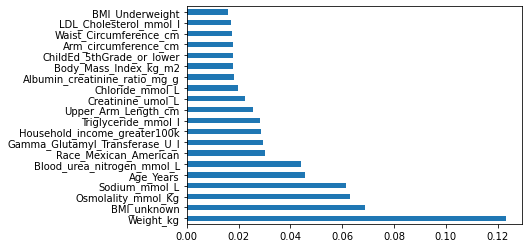

In [ ]:
# find and plot feature importance
y_pred = tab4.predict(training_data['X_test'].values)
tab2.feature_importances_
feat_importances = pd.Series(tab2.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab4.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab4.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")

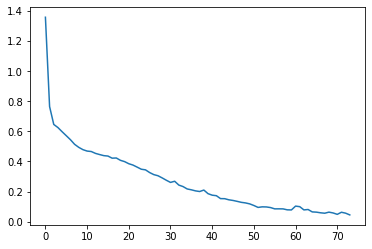

In [ ]:
# plot losses
plt.plot(tab4.history['loss'])


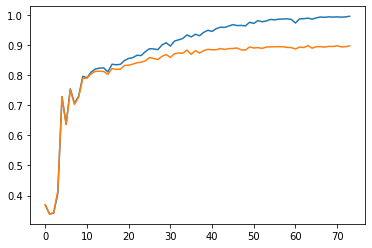

In [ ]:
# plot accuracy
plt.plot(tab4.history['train_balanced_accuracy'])
plt.plot(tab4.history['valid_balanced_accuracy'])


              precision    recall  f1-score   support

     class 1       0.89      0.84      0.86      8396
     class 2       0.51      0.59      0.55      2728
     class 3       0.65      0.63      0.64      1054

    accuracy                           0.77     12178
   macro avg       0.68      0.69      0.69     12178
weighted avg       0.78      0.77      0.77     12178



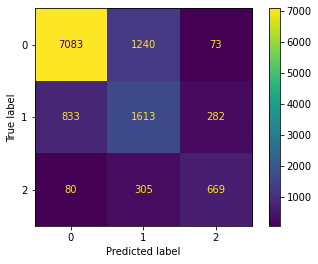

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab4.classes_).plot()
plt.show()

In [ ]:
param_test4 = {'lambda_sparse': [0.0001, 0.001, 0.01, 0.1]}
scoring = ['balanced_accuracy', 'neg_log_loss']
Grid_tab4 = GridSearchCV(estimator=tab4, scoring = scoring, param_grid = param_test4, refit = 'balanced_accuracy', cv = 2, n_jobs=-1)
Grid_tab4.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','balanced_accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42303 | train_logloss: 12.20418| train_balanced_accuracy: 0.39178 | valid_logloss: 12.05193| valid_balanced_accuracy: 0.39104 |  0:00:07s
epoch 1  | loss: 0.80914 | train_logloss: 2.54782 | train_balanced_accuracy: 0.46288 | valid_logloss: 2.53453 | valid_balanced_accuracy: 0.46339 |  0:00:14s
epoch 2  | loss: 0.6765  | train_logloss: 2.56894 | train_balanced_accuracy: 0.50234 | valid_logloss: 2.53596 | valid_balanced_accuracy: 0.50264 |  0:00:21s
epoch 3  | loss: 0.62885 | train_logloss: 3.36016 | train_balanced_accuracy: 0.37565 | valid_logloss: 3.33614 | valid_balanced_accuracy: 0.37514 |  0:00:27s
epoch 4  | loss: 0.59863 | train_logloss: 1.08462 | train_balanced_accuracy: 0.55877 | valid_logloss: 1.08523 | valid_balanced_accuracy: 0.55864 |  0:00:34s
epoch 5  | loss: 0.57464 | train_logloss: 0.72928 | train_balanced_accuracy: 0.69861 | valid_logloss: 0.74509 | valid_balanced_accuracy: 0.69926 |  0:00:41s
epoch 6  | loss: 0.54819 | train_logloss: 0.61546 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 104| loss: 0.01845 | train_logloss: 0.49543 | train_balanced_accuracy: 0.93138 | valid_logloss: 1.01871 | valid_balanced_accuracy: 0.8591  |  0:12:03s
epoch 105| loss: 0.01658 | train_logloss: 0.4845  | train_balanced_accuracy: 0.93348 | valid_logloss: 0.99212 | valid_balanced_accuracy: 0.86323 |  0:12:10s
epoch 106| loss: 0.01553 | train_logloss: 0.49795 | train_balanced_accuracy: 0.93207 | valid_logloss: 1.00492 | valid_balanced_accuracy: 0.86083 |  0:12:17s
epoch 107| loss: 0.02424 | train_logloss: 0.5064  | train_balanced_accuracy: 0.93152 | valid_logloss: 1.02484 | valid_balanced_accuracy: 0.86051 |  0:12:24s
epoch 108| loss: 0.02057 | train_logloss: 0.45769 | train_balanced_accuracy: 0.9319  | valid_logloss: 0.94131 | valid_balanced_accuracy: 0.86191 |  0:12:31s
epoch 109| loss: 0.02366 | train_logloss: 0.47284 | train_balanced_accuracy: 0.93072 | valid_logloss: 0.97593 | valid_balanced_accuracy: 0.85765 |  0:12:38s
epoch 110| loss: 0.02197 | train_logloss: 0.43213 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.0062  | train_logloss: 0.63774 | train_balanced_accuracy: 0.93568 | valid_logloss: 1.33509 | valid_balanced_accuracy: 0.86768 |  0:23:58s
epoch 209| loss: 0.00606 | train_logloss: 0.62688 | train_balanced_accuracy: 0.93526 | valid_logloss: 1.31607 | valid_balanced_accuracy: 0.86497 |  0:24:05s
epoch 210| loss: 0.00537 | train_logloss: 0.63526 | train_balanced_accuracy: 0.93589 | valid_logloss: 1.32335 | valid_balanced_accuracy: 0.86763 |  0:24:12s
epoch 211| loss: 0.00561 | train_logloss: 0.64813 | train_balanced_accuracy: 0.93534 | valid_logloss: 1.34788 | valid_balanced_accuracy: 0.86482 |  0:24:18s
epoch 212| loss: 0.00466 | train_logloss: 0.63556 | train_balanced_accuracy: 0.9361  | valid_logloss: 1.33243 | valid_balanced_accuracy: 0.86744 |  0:24:25s
epoch 213| loss: 0.00476 | train_logloss: 0.64223 | train_balanced_accuracy: 0.9358  | valid_logloss: 1.35111 | valid_balanced_accuracy: 0.86695 |  0:24:32s
epoch 214| loss: 0.00522 | train_logloss: 0.65623 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.00276 | train_logloss: 0.5571  | train_balanced_accuracy: 0.93828 | valid_logloss: 1.16084 | valid_balanced_accuracy: 0.87537 |  0:24:15s
epoch 209| loss: 0.00331 | train_logloss: 0.58475 | train_balanced_accuracy: 0.93652 | valid_logloss: 1.21561 | valid_balanced_accuracy: 0.87187 |  0:24:22s
epoch 210| loss: 0.00224 | train_logloss: 0.56849 | train_balanced_accuracy: 0.93789 | valid_logloss: 1.18203 | valid_balanced_accuracy: 0.87425 |  0:24:29s
epoch 211| loss: 0.00333 | train_logloss: 0.54794 | train_balanced_accuracy: 0.93885 | valid_logloss: 1.14126 | valid_balanced_accuracy: 0.87525 |  0:24:36s
epoch 212| loss: 0.0023  | train_logloss: 0.58048 | train_balanced_accuracy: 0.93739 | valid_logloss: 1.21566 | valid_balanced_accuracy: 0.87159 |  0:24:43s
epoch 213| loss: 0.00211 | train_logloss: 0.58329 | train_balanced_accuracy: 0.93831 | valid_logloss: 1.2133  | valid_balanced_accuracy: 0.87625 |  0:24:50s
epoch 214| loss: 0.00151 | train_logloss: 0.5772  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 141| loss: 0.02644 | train_logloss: 0.38522 | train_balanced_accuracy: 0.93012 | valid_logloss: 0.79314 | valid_balanced_accuracy: 0.85792 |  0:16:01s
epoch 142| loss: 0.02339 | train_logloss: 0.39582 | train_balanced_accuracy: 0.93048 | valid_logloss: 0.80893 | valid_balanced_accuracy: 0.86029 |  0:16:07s
epoch 143| loss: 0.02586 | train_logloss: 0.41006 | train_balanced_accuracy: 0.93023 | valid_logloss: 0.83173 | valid_balanced_accuracy: 0.86096 |  0:16:13s
epoch 144| loss: 0.02809 | train_logloss: 0.39199 | train_balanced_accuracy: 0.93041 | valid_logloss: 0.79208 | valid_balanced_accuracy: 0.86121 |  0:16:18s
epoch 145| loss: 0.02448 | train_logloss: 0.38607 | train_balanced_accuracy: 0.93071 | valid_logloss: 0.78865 | valid_balanced_accuracy: 0.85998 |  0:16:24s
epoch 146| loss: 0.02769 | train_logloss: 0.38306 | train_balanced_accuracy: 0.92989 | valid_logloss: 0.77987 | valid_balanced_accuracy: 0.85918 |  0:16:30s
epoch 147| loss: 0.02503 | train_logloss: 0.39122 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.00469 | train_logloss: 0.5599  | train_balanced_accuracy: 0.93666 | valid_logloss: 1.15705 | valid_balanced_accuracy: 0.87386 |  0:24:11s
epoch 209| loss: 0.00354 | train_logloss: 0.57622 | train_balanced_accuracy: 0.93652 | valid_logloss: 1.19355 | valid_balanced_accuracy: 0.87236 |  0:24:18s
epoch 210| loss: 0.00327 | train_logloss: 0.57094 | train_balanced_accuracy: 0.93599 | valid_logloss: 1.18175 | valid_balanced_accuracy: 0.87385 |  0:24:25s
epoch 211| loss: 0.00468 | train_logloss: 0.5703  | train_balanced_accuracy: 0.93552 | valid_logloss: 1.18872 | valid_balanced_accuracy: 0.86979 |  0:24:32s
epoch 212| loss: 0.00441 | train_logloss: 0.66593 | train_balanced_accuracy: 0.92759 | valid_logloss: 1.36017 | valid_balanced_accuracy: 0.858   |  0:24:39s
epoch 213| loss: 0.00462 | train_logloss: 0.57232 | train_balanced_accuracy: 0.93529 | valid_logloss: 1.18137 | valid_balanced_accuracy: 0.87148 |  0:24:46s
epoch 214| loss: 0.00288 | train_logloss: 0.57982 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.0393  | train_logloss: 4.39495 | train_balanced_accuracy: 0.34687 | valid_logloss: 4.32769 | valid_balanced_accuracy: 0.35029 |  0:00:06s
epoch 1  | loss: 0.6685  | train_logloss: 1.3238  | train_balanced_accuracy: 0.43018 | valid_logloss: 1.31595 | valid_balanced_accuracy: 0.4281  |  0:00:13s
epoch 2  | loss: 0.6096  | train_logloss: 0.72228 | train_balanced_accuracy: 0.65961 | valid_logloss: 0.72284 | valid_balanced_accuracy: 0.66117 |  0:00:19s
epoch 3  | loss: 0.54941 | train_logloss: 0.5383  | train_balanced_accuracy: 0.75815 | valid_logloss: 0.54601 | valid_balanced_accuracy: 0.75516 |  0:00:26s
epoch 4  | loss: 0.50237 | train_logloss: 0.49962 | train_balanced_accuracy: 0.78669 | valid_logloss: 0.51805 | valid_balanced_accuracy: 0.78028 |  0:00:33s
epoch 5  | loss: 0.48053 | train_logloss: 0.48655 | train_balanced_accuracy: 0.79083 | valid_logloss: 0.49689 | valid_balanced_accuracy: 0.78763 |  0:00:40s
epoch 6  | loss: 0.47166 | train_logloss: 0.465   | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=2,
             estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], input_dim=68, mask_type='entmax', n_d=128, n_steps=7, optimizer_params={'lr': 0.02}, output_dim=3, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.9, 'step_size': 10}, seed=42),
             n_jobs=-1,
             param_grid={'lambda_sparse': [0.0001, 0.001, 0.01, 0.1]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'neg_log_loss'])

In [ ]:
Grid_tab4.best_estimator_

TabNetClassifier(n_d=128, n_a=8, n_steps=7, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='entmax', input_dim=68, output_dim=3, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [ ]:
tab5 = TabNetClassifier(n_d=128, 
                        n_a=8, 
                        n_steps=7, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn=torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=68, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab5.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 1.36018 | train_logloss: 6.64583 | train_balanced_accuracy: 0.35578 | valid_logloss: 6.5364  | valid_balanced_accuracy: 0.35447 |  0:00:05s
epoch 1  | loss: 0.72488 | train_logloss: 4.77606 | train_balanced_accuracy: 0.38095 | valid_logloss: 4.79091 | valid_balanced_accuracy: 0.37702 |  0:00:10s
epoch 2  | loss: 0.65684 | train_logloss: 3.4324  | train_balanced_accuracy: 0.4218  | valid_logloss: 3.41665 | valid_balanced_accuracy: 0.42262 |  0:00:15s
epoch 3  | loss: 0.60142 | train_logloss: 1.3486  | train_balanced_accuracy: 0.54968 | valid_logloss: 1.32498 | valid_balanced_accuracy: 0.55548 |  0:00:20s
epoch 4  | loss: 0.57246 | train_logloss: 1.28257 | train_balanced_accuracy: 0.50525 | valid_logloss: 1.27974 | valid_balanced_accuracy: 0.50949 |  0:00:26s
epoch 5  | loss: 0.5404  | train_logloss: 0.70354 | train_balanced_accuracy: 0.6651  | valid_logloss: 0.70472 | valid_balanced_accuracy: 0.66209 |  0:00:30s
epoch 6  | loss: 0.50428 | train_logloss: 0.5269  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.8908181891471654
BEST ACCURACY SCORE ON TEST SET : 0.6834582264388054
BEST f1_weighted SCORE ON VALIDATION SET : 0.8892319795863707
BEST f1_weighted SCORE ON TEST SET : 0.7594702191022037
BEST fbeta SCORE ON VALIDATION SET : 0.8892319795863707
BEST fbeta SCORE ON TEST SET : 0.7594702191022037


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


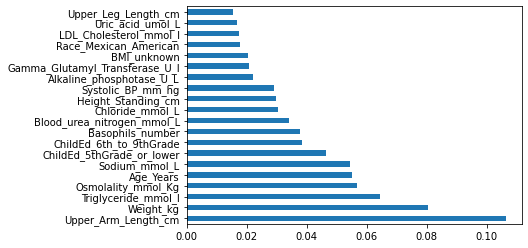

In [ ]:
# find and plot feature importance
y_pred = tab5.predict(training_data['X_test'].values)
tab5.feature_importances_
feat_importances = pd.Series(tab5.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab5.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab5.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")

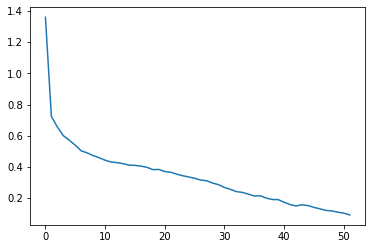

In [ ]:
# plot losses
plt.plot(tab5.history['loss'])


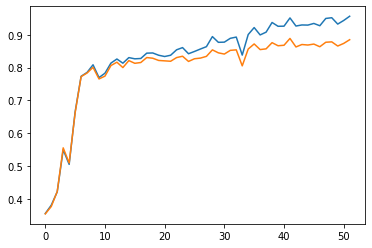

In [ ]:
# plot accuracy
plt.plot(tab5.history['train_balanced_accuracy'])
plt.plot(tab5.history['valid_balanced_accuracy'])

              precision    recall  f1-score   support

     class 1       0.91      0.82      0.86      8396
     class 2       0.51      0.67      0.58      2728
     class 3       0.63      0.66      0.64      1054

    accuracy                           0.77     12178
   macro avg       0.68      0.71      0.69     12178
weighted avg       0.80      0.77      0.78     12178



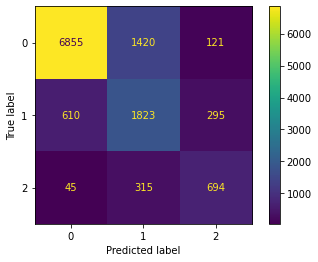

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab5.classes_).plot()
plt.show()

In [ ]:
param_test5 = {'n_a': [8, 16, 32, 64]}
scoring = ['balanced_accuracy', 'neg_log_loss']
Grid_tab5 = GridSearchCV(estimator=tab5, scoring = scoring, param_grid = param_test5, refit = 'balanced_accuracy', cv = 2, n_jobs=-1)
Grid_tab5.fit(training_data['X_train'].values, training_data['y_train'], 
               eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
               eval_name=['train', 'valid'],
               eval_metric=['logloss','balanced_accuracy'],
               max_epochs=1000 , patience=50,
               batch_size=512, virtual_batch_size=256,
               num_workers=0, 
               weights=1,
               drop_last=False)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37201 | train_logloss: 11.10541| train_balanced_accuracy: 0.34023 | valid_logloss: 11.05863| valid_balanced_accuracy: 0.33592 |  0:00:07s
epoch 1  | loss: 0.79403 | train_logloss: 12.31824| train_balanced_accuracy: 0.42419 | valid_logloss: 12.1704 | valid_balanced_accuracy: 0.42344 |  0:00:14s
epoch 2  | loss: 0.70605 | train_logloss: 2.25865 | train_balanced_accuracy: 0.52153 | valid_logloss: 2.17324 | valid_balanced_accuracy: 0.52603 |  0:00:21s
epoch 3  | loss: 0.65274 | train_logloss: 1.96608 | train_balanced_accuracy: 0.52592 | valid_logloss: 1.92022 | valid_balanced_accuracy: 0.52871 |  0:00:28s
epoch 4  | loss: 0.62745 | train_logloss: 1.08475 | train_balanced_accuracy: 0.57714 | valid_logloss: 1.07084 | valid_balanced_accuracy: 0.57615 |  0:00:34s
epoch 5  | loss: 0.58603 | train_logloss: 0.74283 | train_balanced_accuracy: 0.67072 | valid_logloss: 0.74395 | valid_balanced_accuracy: 0.66997 |  0:00:41s
epoch 6  | loss: 0.55372 | train_logloss: 0.59837 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 104| loss: 0.01259 | train_logloss: 0.4342  | train_balanced_accuracy: 0.93537 | valid_logloss: 0.87523 | valid_balanced_accuracy: 0.8672  |  0:12:09s
epoch 105| loss: 0.01554 | train_logloss: 0.42471 | train_balanced_accuracy: 0.93538 | valid_logloss: 0.86571 | valid_balanced_accuracy: 0.86846 |  0:12:16s
epoch 106| loss: 0.01382 | train_logloss: 0.43214 | train_balanced_accuracy: 0.93568 | valid_logloss: 0.87928 | valid_balanced_accuracy: 0.86742 |  0:12:23s
epoch 107| loss: 0.0145  | train_logloss: 0.42753 | train_balanced_accuracy: 0.93492 | valid_logloss: 0.8722  | valid_balanced_accuracy: 0.86834 |  0:12:29s
epoch 108| loss: 0.01745 | train_logloss: 0.44207 | train_balanced_accuracy: 0.93341 | valid_logloss: 0.8845  | valid_balanced_accuracy: 0.86841 |  0:12:36s
epoch 109| loss: 0.01779 | train_logloss: 0.42095 | train_balanced_accuracy: 0.93461 | valid_logloss: 0.84258 | valid_balanced_accuracy: 0.86941 |  0:12:43s
epoch 110| loss: 0.01283 | train_logloss: 0.43114 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 156| loss: 0.00556 | train_logloss: 0.48021 | train_balanced_accuracy: 0.93725 | valid_logloss: 1.02857 | valid_balanced_accuracy: 0.86947 |  0:18:17s
epoch 157| loss: 0.0056  | train_logloss: 0.50164 | train_balanced_accuracy: 0.93745 | valid_logloss: 1.06613 | valid_balanced_accuracy: 0.87067 |  0:18:24s
epoch 158| loss: 0.00714 | train_logloss: 0.51149 | train_balanced_accuracy: 0.93542 | valid_logloss: 1.08316 | valid_balanced_accuracy: 0.86987 |  0:18:31s
epoch 159| loss: 0.00558 | train_logloss: 0.49903 | train_balanced_accuracy: 0.93608 | valid_logloss: 1.07767 | valid_balanced_accuracy: 0.8696  |  0:18:38s
epoch 160| loss: 0.00584 | train_logloss: 0.50531 | train_balanced_accuracy: 0.93644 | valid_logloss: 1.08916 | valid_balanced_accuracy: 0.8687  |  0:18:45s
epoch 161| loss: 0.00543 | train_logloss: 0.50247 | train_balanced_accuracy: 0.93687 | valid_logloss: 1.08483 | valid_balanced_accuracy: 0.86826 |  0:18:52s
epoch 162| loss: 0.00618 | train_logloss: 0.48944 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 208| loss: 0.00268 | train_logloss: 0.57482 | train_balanced_accuracy: 0.93688 | valid_logloss: 1.17556 | valid_balanced_accuracy: 0.86962 |  0:24:24s

Early stopping occurred at epoch 208 with best_epoch = 158 and best_valid_balanced_accuracy = 0.87207
epoch 0  | loss: 1.20152 | train_logloss: 22.9933 | train_balanced_accuracy: 0.23048 | valid_logloss: 23.12547| valid_balanced_accuracy: 0.23181 |  0:00:07s
epoch 1  | loss: 0.72531 | train_logloss: 7.5369  | train_balanced_accuracy: 0.35971 | valid_logloss: 7.59183 | valid_balanced_accuracy: 0.35857 |  0:00:14s
epoch 2  | loss: 0.66455 | train_logloss: 3.48948 | train_balanced_accuracy: 0.27534 | valid_logloss: 3.45724 | valid_balanced_accuracy: 0.27637 |  0:00:21s
epoch 3  | loss: 0.64535 | train_logloss: 1.22318 | train_balanced_accuracy: 0.53124 | valid_logloss: 1.22192 | valid_balanced_accuracy: 0.53232 |  0:00:29s
epoch 4  | loss: 0.61618 | train_logloss: 0.89402 | train_balanced_accuracy: 0.58692 | valid_logloss: 0.89263 | 

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 85 | loss: 0.0178  | train_logloss: 0.4458  | train_balanced_accuracy: 0.93303 | valid_logloss: 0.91198 | valid_balanced_accuracy: 0.8616  |  0:10:13s
epoch 86 | loss: 0.01379 | train_logloss: 0.53926 | train_balanced_accuracy: 0.91869 | valid_logloss: 1.05642 | valid_balanced_accuracy: 0.84982 |  0:10:21s
epoch 87 | loss: 0.0186  | train_logloss: 0.49434 | train_balanced_accuracy: 0.92626 | valid_logloss: 0.98524 | valid_balanced_accuracy: 0.85754 |  0:10:28s
epoch 88 | loss: 0.01735 | train_logloss: 0.52067 | train_balanced_accuracy: 0.92565 | valid_logloss: 1.05588 | valid_balanced_accuracy: 0.8516  |  0:10:35s
epoch 89 | loss: 0.02025 | train_logloss: 0.42128 | train_balanced_accuracy: 0.93487 | valid_logloss: 0.85673 | valid_balanced_accuracy: 0.86674 |  0:10:42s
epoch 90 | loss: 0.01192 | train_logloss: 0.4696  | train_balanced_accuracy: 0.93233 | valid_logloss: 0.96188 | valid_balanced_accuracy: 0.86256 |  0:10:49s
epoch 91 | loss: 0.01194 | train_logloss: 0.4358  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06253 | train_logloss: 4.26956 | train_balanced_accuracy: 0.46994 | valid_logloss: 4.2481  | valid_balanced_accuracy: 0.46926 |  0:00:06s
epoch 1  | loss: 0.71147 | train_logloss: 1.08097 | train_balanced_accuracy: 0.54382 | valid_logloss: 1.08373 | valid_balanced_accuracy: 0.54426 |  0:00:13s
epoch 2  | loss: 0.67001 | train_logloss: 0.71047 | train_balanced_accuracy: 0.66727 | valid_logloss: 0.71552 | valid_balanced_accuracy: 0.66592 |  0:00:19s
epoch 3  | loss: 0.60247 | train_logloss: 0.5604  | train_balanced_accuracy: 0.74481 | valid_logloss: 0.56781 | valid_balanced_accuracy: 0.74135 |  0:00:26s
epoch 4  | loss: 0.52864 | train_logloss: 0.56326 | train_balanced_accuracy: 0.75874 | valid_logloss: 0.57616 | valid_balanced_accuracy: 0.74986 |  0:00:33s
epoch 5  | loss: 0.4949  | train_logloss: 0.47911 | train_balanced_accuracy: 0.79067 | valid_logloss: 0.48785 | valid_balanced_accuracy: 0.78716 |  0:00:39s
epoch 6  | loss: 0.48236 | train_logloss: 0.46104 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


GridSearchCV(cv=2,
             estimator=TabNetClassifier(cat_dims=[], cat_idxs=[], input_dim=68, mask_type='entmax', n_d=128, n_steps=7, optimizer_params={'lr': 0.02}, output_dim=3, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.9, 'step_size': 10}, seed=42),
             n_jobs=-1, param_grid={'n_a': [8, 16, 32, 64]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'neg_log_loss'])

In [ ]:
Grid_tab5.best_estimator_

TabNetClassifier(n_d=128, n_a=32, n_steps=7, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='entmax', input_dim=68, output_dim=3, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [ ]:
tab6 = TabNetClassifier(n_d=128,
                        n_a=32, 
                        n_steps=7, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, clip_value=1, 
                        verbose=1, optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn=torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', input_dim=68, output_dim=3, 
                        device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab6.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 1.20243 | train_logloss: 11.93554| train_balanced_accuracy: 0.33831 | valid_logloss: 11.89496| valid_balanced_accuracy: 0.33619 |  0:00:04s
epoch 1  | loss: 0.80235 | train_logloss: 1.95683 | train_balanced_accuracy: 0.37337 | valid_logloss: 1.95446 | valid_balanced_accuracy: 0.37109 |  0:00:10s
epoch 2  | loss: 0.69809 | train_logloss: 3.83137 | train_balanced_accuracy: 0.42251 | valid_logloss: 3.77532 | valid_balanced_accuracy: 0.42047 |  0:00:15s
epoch 3  | loss: 0.66689 | train_logloss: 1.73664 | train_balanced_accuracy: 0.53116 | valid_logloss: 1.73084 | valid_balanced_accuracy: 0.52921 |  0:00:20s
epoch 4  | loss: 0.64807 | train_logloss: 0.8889  | train_balanced_accuracy: 0.61384 | valid_logloss: 0.88518 | valid_balanced_accuracy: 0.61206 |  0:00:25s
epoch 5  | loss: 0.6237  | train_logloss: 0.71004 | train_balanced_accuracy: 0.67586 | valid_logloss: 0.71289 | valid_balanced_accuracy: 0.67028 |  0:00:30s
epoch 6  | loss: 0.60149 | train_logloss: 0.63408 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.8363768401276716
BEST ACCURACY SCORE ON TEST SET : 0.7258637516449443
BEST f1_weighted SCORE ON VALIDATION SET : 0.824926589223691
BEST f1_weighted SCORE ON TEST SET : 0.7798176172068688
BEST fbeta SCORE ON VALIDATION SET : 0.824926589223691
BEST fbeta SCORE ON TEST SET : 0.7798176172068688


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


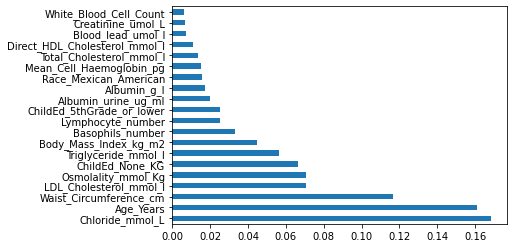

In [ ]:
# find and plot feature importance
y_pred = tab6.predict(training_data['X_test'].values)
tab6.feature_importances_
feat_importances = pd.Series(tab6.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab6.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab6.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")

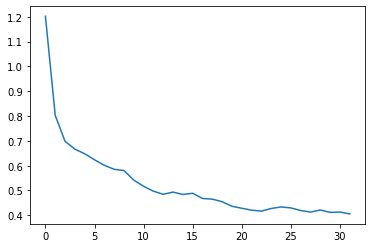

In [ ]:
# plot losses
plt.plot(tab6.history['loss'])

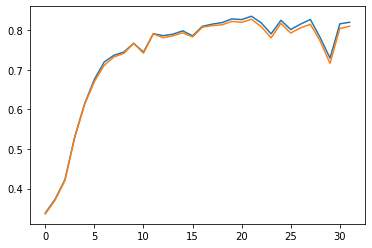

In [ ]:
# plot accuracy
plt.plot(tab6.history['train_balanced_accuracy'])
plt.plot(tab6.history['valid_balanced_accuracy'])

              precision    recall  f1-score   support

     class 1       0.92      0.83      0.87      8396
     class 2       0.53      0.70      0.61      2728
     class 3       0.73      0.70      0.71      1054

    accuracy                           0.79     12178
   macro avg       0.73      0.74      0.73     12178
weighted avg       0.81      0.79      0.80     12178



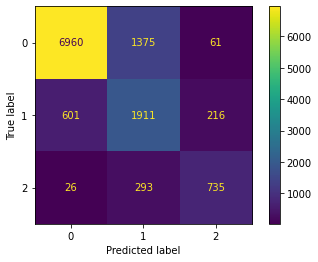

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab6.classes_).plot()
plt.show()

In [ ]:
tab_64 = TabNetClassifier(n_d=64, 
                        n_a=64, 
                        n_steps=3, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab_64.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'])

epoch 0  | loss: 0.8052  | train_logloss: 9.94353 | train_balanced_accuracy: 0.29713 | valid_logloss: 9.92453 | valid_balanced_accuracy: 0.2952  |  0:00:02s
epoch 1  | loss: 0.58421 | train_logloss: 5.22163 | train_balanced_accuracy: 0.27282 | valid_logloss: 5.1879  | valid_balanced_accuracy: 0.27339 |  0:00:05s
epoch 2  | loss: 0.50661 | train_logloss: 2.01595 | train_balanced_accuracy: 0.34356 | valid_logloss: 2.00088 | valid_balanced_accuracy: 0.34249 |  0:00:08s
epoch 3  | loss: 0.45918 | train_logloss: 0.79845 | train_balanced_accuracy: 0.60952 | valid_logloss: 0.79714 | valid_balanced_accuracy: 0.60315 |  0:00:11s
epoch 4  | loss: 0.43355 | train_logloss: 0.86136 | train_balanced_accuracy: 0.58874 | valid_logloss: 0.86811 | valid_balanced_accuracy: 0.58707 |  0:00:14s
epoch 5  | loss: 0.4182  | train_logloss: 0.49842 | train_balanced_accuracy: 0.78629 | valid_logloss: 0.52065 | valid_balanced_accuracy: 0.77304 |  0:00:16s
epoch 6  | loss: 0.38327 | train_logloss: 0.44156 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9087757510618335
BEST ACCURACY SCORE ON TEST SET : 0.6871548697936376
BEST f1_weighted SCORE ON VALIDATION SET : 0.9096011598810166
BEST f1_weighted SCORE ON TEST SET : 0.7721216034245347
BEST fbeta SCORE ON VALIDATION SET : 0.9096011598810166
BEST fbeta SCORE ON TEST SET : 0.7721216034245347


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


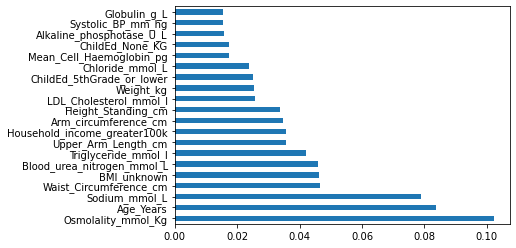

In [ ]:
# find and plot feature importance
y_pred = tab_64.predict(training_data['X_test'].values)
tab_64.feature_importances_
feat_importances = pd.Series(tab_64.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab_64.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab_64.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


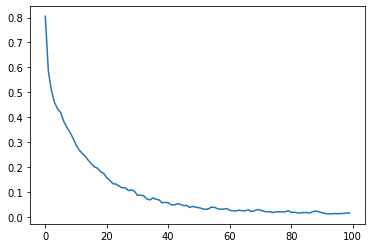

In [ ]:
# plot losses
plt.plot(tab_64.history['loss'])



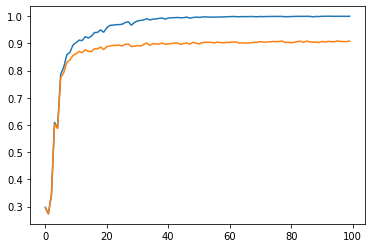

In [ ]:
# plot accuracy
plt.plot(tab_64.history['train_balanced_accuracy'])
plt.plot(tab_64.history['valid_balanced_accuracy'])


              precision    recall  f1-score   support

     class 1       0.87      0.86      0.87      8396
     class 2       0.53      0.56      0.54      2728
     class 3       0.66      0.65      0.66      1054

    accuracy                           0.77     12178
   macro avg       0.69      0.69      0.69     12178
weighted avg       0.78      0.77      0.78     12178



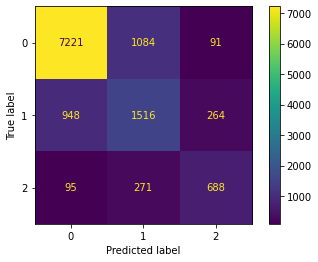

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab_64.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab_64.classes_).plot()
plt.show()

In [ ]:
tab_128 = TabNetClassifier(n_d=128, 
                        n_a=128, 
                        n_steps=3, 
                        gamma=1.3, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab_128.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'],
    max_epochs=200, patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False)

epoch 0  | loss: 0.81347 | train_logloss: 1.12    | train_balanced_accuracy: 0.53924 | valid_logloss: 1.12283 | valid_balanced_accuracy: 0.54326 |  0:00:14s
epoch 1  | loss: 0.57237 | train_logloss: 0.52476 | train_balanced_accuracy: 0.76464 | valid_logloss: 0.54746 | valid_balanced_accuracy: 0.75447 |  0:00:29s
epoch 2  | loss: 0.49058 | train_logloss: 0.46117 | train_balanced_accuracy: 0.80615 | valid_logloss: 0.50263 | valid_balanced_accuracy: 0.78515 |  0:00:45s
epoch 3  | loss: 0.42898 | train_logloss: 0.3696  | train_balanced_accuracy: 0.84327 | valid_logloss: 0.42715 | valid_balanced_accuracy: 0.82119 |  0:01:00s
epoch 4  | loss: 0.37226 | train_logloss: 0.35452 | train_balanced_accuracy: 0.85635 | valid_logloss: 0.43756 | valid_balanced_accuracy: 0.82897 |  0:01:13s
epoch 5  | loss: 0.3272  | train_logloss: 0.27183 | train_balanced_accuracy: 0.88937 | valid_logloss: 0.34631 | valid_balanced_accuracy: 0.85995 |  0:01:27s
epoch 6  | loss: 0.28765 | train_logloss: 0.24973 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9397806021410743
BEST ACCURACY SCORE ON TEST SET : 0.6620551707618207
BEST f1_weighted SCORE ON VALIDATION SET : 0.9384601258326934
BEST f1_weighted SCORE ON TEST SET : 0.7606673239216256
BEST fbeta SCORE ON VALIDATION SET : 0.9384601258326934
BEST fbeta SCORE ON TEST SET : 0.7606673239216256


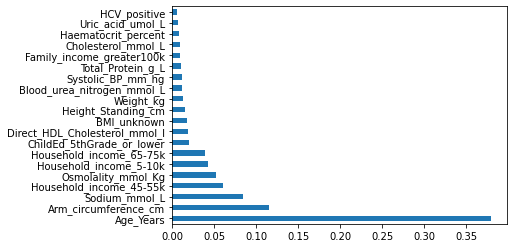

In [ ]:
# find and plot feature importance
y_pred = tab_128.predict(training_data['X_test'].values)
tab_128.feature_importances_
feat_importances = pd.Series(tab_128.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab_128.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab_128.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


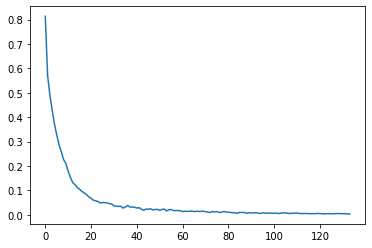

In [ ]:
# plot losses
plt.plot(tab_128.history['loss'])



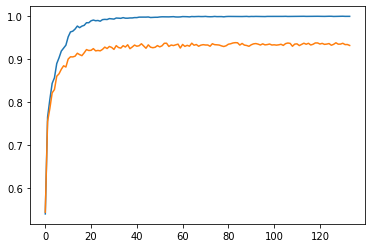

In [ ]:
# plot accuracy
plt.plot(tab_128.history['train_balanced_accuracy'])
plt.plot(tab_128.history['valid_balanced_accuracy'])


              precision    recall  f1-score   support

     class 1       0.86      0.87      0.86      8419
     class 2       0.50      0.51      0.50      2692
     class 3       0.63      0.56      0.59      1067

    accuracy                           0.76     12178
   macro avg       0.66      0.64      0.65     12178
weighted avg       0.76      0.76      0.76     12178



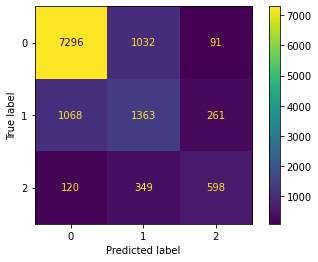

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab_128.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab_128.classes_).plot()
plt.show()

In [ ]:
tab_64 = TabNetClassifier(n_d=64, 
                        n_a=64, 
                        n_steps=3, 
                        gamma=2.0, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab_64.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'],
    max_epochs=200, patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False)

epoch 0  | loss: 0.83891 | train_logloss: 0.94856 | train_balanced_accuracy: 0.5497  | valid_logloss: 0.94237 | valid_balanced_accuracy: 0.5457  |  0:00:12s
epoch 1  | loss: 0.61775 | train_logloss: 0.55923 | train_balanced_accuracy: 0.75497 | valid_logloss: 0.57347 | valid_balanced_accuracy: 0.74705 |  0:00:24s
epoch 2  | loss: 0.53237 | train_logloss: 0.51989 | train_balanced_accuracy: 0.77002 | valid_logloss: 0.54099 | valid_balanced_accuracy: 0.75561 |  0:00:36s
epoch 3  | loss: 0.49152 | train_logloss: 0.46638 | train_balanced_accuracy: 0.79771 | valid_logloss: 0.49932 | valid_balanced_accuracy: 0.78021 |  0:00:49s
epoch 4  | loss: 0.44139 | train_logloss: 0.4088  | train_balanced_accuracy: 0.83359 | valid_logloss: 0.45188 | valid_balanced_accuracy: 0.81231 |  0:01:01s
epoch 5  | loss: 0.39303 | train_logloss: 0.34765 | train_balanced_accuracy: 0.85823 | valid_logloss: 0.40735 | valid_balanced_accuracy: 0.82917 |  0:01:12s
epoch 6  | loss: 0.36076 | train_logloss: 0.29779 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9366837542966703
BEST ACCURACY SCORE ON TEST SET : 0.6754640574601979
BEST f1_weighted SCORE ON VALIDATION SET : 0.9354154225248152
BEST f1_weighted SCORE ON TEST SET : 0.7684707058230903
BEST fbeta SCORE ON VALIDATION SET : 0.9354154225248152
BEST fbeta SCORE ON TEST SET : 0.7684707058230903


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


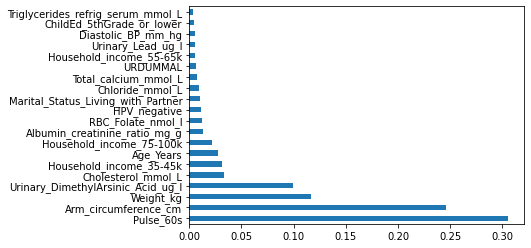

In [ ]:
# find and plot feature importance
y_pred = tab_64.predict(training_data['X_test'].values)
tab_64.feature_importances_
feat_importances = pd.Series(tab_64.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab_64.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab_64.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


              precision    recall  f1-score   support

     class 1       0.87      0.86      0.87      8419
     class 2       0.51      0.54      0.53      2692
     class 3       0.64      0.60      0.62      1067

    accuracy                           0.77     12178
   macro avg       0.68      0.67      0.67     12178
weighted avg       0.77      0.77      0.77     12178



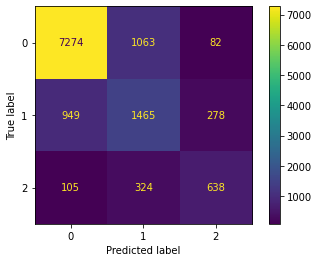

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab_64.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab_64.classes_).plot()
plt.show()

In [ ]:
tab_64 = TabNetClassifier(n_d=64, 
                        n_a=64, 
                        n_steps=6, 
                        gamma=2.0, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.9}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab_64.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'],
    max_epochs=200, patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False)

epoch 0  | loss: 1.02675 | train_logloss: 0.93632 | train_balanced_accuracy: 0.54821 | valid_logloss: 0.93959 | valid_balanced_accuracy: 0.54846 |  0:00:19s
epoch 1  | loss: 0.75818 | train_logloss: 0.69394 | train_balanced_accuracy: 0.67922 | valid_logloss: 0.69364 | valid_balanced_accuracy: 0.67965 |  0:00:39s
epoch 2  | loss: 0.6569  | train_logloss: 0.58003 | train_balanced_accuracy: 0.73667 | valid_logloss: 0.59225 | valid_balanced_accuracy: 0.7289  |  0:01:01s
epoch 3  | loss: 0.57717 | train_logloss: 0.53125 | train_balanced_accuracy: 0.76669 | valid_logloss: 0.54616 | valid_balanced_accuracy: 0.75778 |  0:01:22s
epoch 4  | loss: 0.52852 | train_logloss: 0.48125 | train_balanced_accuracy: 0.79474 | valid_logloss: 0.50189 | valid_balanced_accuracy: 0.78339 |  0:01:44s
epoch 5  | loss: 0.48305 | train_logloss: 0.42733 | train_balanced_accuracy: 0.82185 | valid_logloss: 0.46042 | valid_balanced_accuracy: 0.80329 |  0:02:04s
epoch 6  | loss: 0.42777 | train_logloss: 0.3912  | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9383173199133762
BEST ACCURACY SCORE ON TEST SET : 0.6671271236151141
BEST f1_weighted SCORE ON VALIDATION SET : 0.9376898032440504
BEST f1_weighted SCORE ON TEST SET : 0.7655219894615896
BEST fbeta SCORE ON VALIDATION SET : 0.9376898032440504
BEST fbeta SCORE ON TEST SET : 0.7655219894615896


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


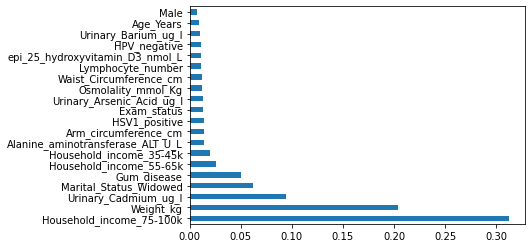

In [ ]:
# find and plot feature importance
y_pred = tab_64.predict(training_data['X_test'].values)
tab_64.feature_importances_
feat_importances = pd.Series(tab_64.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab_64.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab_64.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


              precision    recall  f1-score   support

     class 1       0.87      0.86      0.87      8419
     class 2       0.51      0.52      0.52      2692
     class 3       0.62      0.60      0.61      1067

    accuracy                           0.77     12178
   macro avg       0.67      0.66      0.66     12178
weighted avg       0.77      0.77      0.77     12178



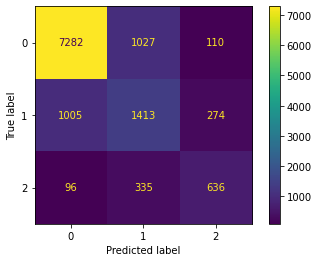

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab_64.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab_64.classes_).plot()
plt.show()

In [ ]:
tab32 = TabNetClassifier(n_d=32, 
                        n_a=32, 
                        n_steps=3, 
                        gamma=2.0, 
                        cat_idxs=[], 
                        cat_dims=[], 
                        cat_emb_dim=1, 
                        n_independent=2, 
                        n_shared=2, 
                        epsilon=1e-15, 
                        momentum=0.02, 
                        lambda_sparse=0.001, 
                        seed=42, 
                        clip_value=1, 
                        verbose=1, 
                        optimizer_fn=torch.optim.Adam, 
                        optimizer_params={'lr': 0.02}, 
                        scheduler_fn= torch.optim.lr_scheduler.StepLR, 
                        scheduler_params={'step_size': 10, 'gamma': 0.1}, 
                        mask_type='entmax', 
                        input_dim=177, 
                        output_dim=3, 
                        device_name='auto', 
                        n_shared_decoder=1, 
                        n_indep_decoder=1)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tab32.fit(X_train=training_data['X_train'].values, y_train=training_data['y_train'],
    eval_set=[(training_data['X_train'].values, training_data['y_train']), (training_data['X_val'].values, training_data['y_val'])],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','balanced_accuracy'],
    max_epochs=200, patience=20,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False)

epoch 0  | loss: 0.85103 | train_logloss: 0.9204  | train_balanced_accuracy: 0.51031 | valid_logloss: 0.91971 | valid_balanced_accuracy: 0.51257 |  0:00:11s
epoch 1  | loss: 0.61622 | train_logloss: 0.54596 | train_balanced_accuracy: 0.75418 | valid_logloss: 0.5618  | valid_balanced_accuracy: 0.74551 |  0:00:23s
epoch 2  | loss: 0.52018 | train_logloss: 0.47061 | train_balanced_accuracy: 0.79833 | valid_logloss: 0.49787 | valid_balanced_accuracy: 0.78697 |  0:00:35s
epoch 3  | loss: 0.48214 | train_logloss: 0.42728 | train_balanced_accuracy: 0.82025 | valid_logloss: 0.46764 | valid_balanced_accuracy: 0.79939 |  0:00:47s
epoch 4  | loss: 0.43778 | train_logloss: 0.38962 | train_balanced_accuracy: 0.83583 | valid_logloss: 0.43988 | valid_balanced_accuracy: 0.81193 |  0:00:59s
epoch 5  | loss: 0.38724 | train_logloss: 0.3484  | train_balanced_accuracy: 0.85472 | valid_logloss: 0.40248 | valid_balanced_accuracy: 0.82719 |  0:01:10s
epoch 6  | loss: 0.36347 | train_logloss: 0.33523 | train_

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


BEST ACCURACY SCORE ON VALIDATION SET : 0.9127571707206007
BEST ACCURACY SCORE ON TEST SET : 0.6862763262684317
BEST f1_weighted SCORE ON VALIDATION SET : 0.9122034672505475
BEST f1_weighted SCORE ON TEST SET : 0.7553128445517248
BEST fbeta SCORE ON VALIDATION SET : 0.9122034672505475
BEST fbeta SCORE ON TEST SET : 0.7553128445517248


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


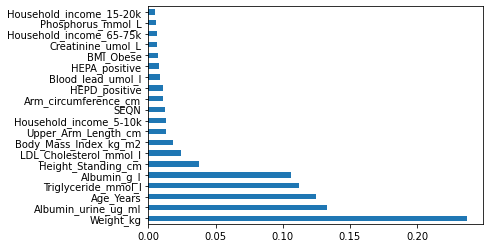

In [ ]:
# find and plot feature importance
y_pred = tab32.predict(training_data['X_test'].values)
tab32.feature_importances_
feat_importances = pd.Series(tab32.feature_importances_, index=train_features)
feat_importances.nlargest(20).plot(kind='barh')


# determine best accuracy for test set
preds = tab32.predict(training_data['X_test'].values)
test_acc = balanced_accuracy_score(preds, training_data['y_test'])
test_f1 = f1_score(preds, training_data['y_test'], average = 'weighted')
test_fbeta = fbeta_score(preds, training_data['y_test'], beta = 2, labels = [1, 2, 3], average = 'weighted')

# determine best accuracy for validation set
preds_valid = tab32.predict(training_data['X_val'].values)
valid_acc = balanced_accuracy_score(preds_valid, training_data['y_val'])
valid_f1 = f1_score(preds_valid, training_data['y_val'], average = 'weighted')
valid_fbeta = fbeta_score(preds_valid, training_data['y_val'], beta = 2, labels = [1, 2, 3], average = 'weighted')

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")
print(f"BEST f1_weighted SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST f1_weighted SCORE ON TEST SET : {test_f1}")
print(f"BEST fbeta SCORE ON VALIDATION SET : {valid_f1}")
print(f"BEST fbeta SCORE ON TEST SET : {test_f1}")


              precision    recall  f1-score   support

     class 1       0.90      0.82      0.86      8419
     class 2       0.49      0.66      0.56      2692
     class 3       0.66      0.58      0.62      1067

    accuracy                           0.76     12178
   macro avg       0.69      0.69      0.68     12178
weighted avg       0.79      0.76      0.77     12178



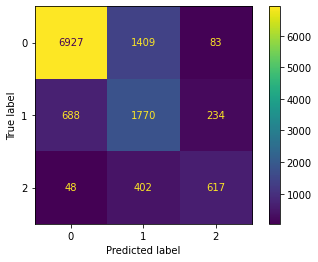

In [ ]:
target_names = ['class 1', 'class 2', 'class 3']
print(classification_report(training_data['y_test'], y_pred, target_names=target_names))
cm = confusion_matrix(training_data['y_test'], y_pred, labels=tab32.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tab32.classes_).plot()
plt.show()

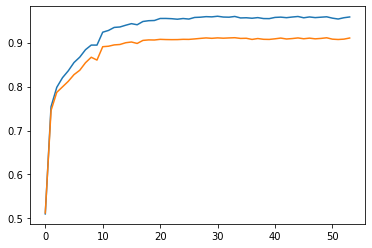

In [ ]:
# plot accuracy
plt.plot(tab32.history['train_balanced_accuracy'])
plt.plot(tab32.history['valid_balanced_accuracy'])


In [ ]:
y_score = tab6.predict_proba(training_data['X_test'].values)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


In [ ]:

y_train = pd.read_csv('/notebooks/Data/y_train_SMOV.csv', index_col=[0])

y_test = pd.read_csv('/notebooks/Data/y_test.csv', index_col=[0])

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(12178, 3)

In [ ]:
class_of_interest = 1 # normal
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

1

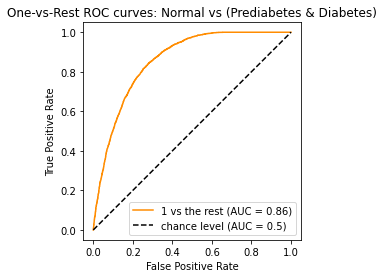

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Normal vs (Prediabetes & Diabetes)")
plt.legend()
plt.show()

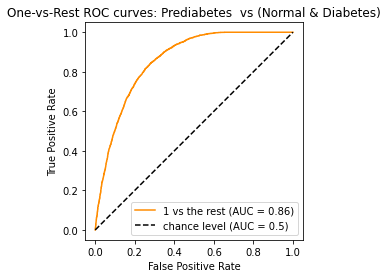

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, 1],
    y_score[:, 1],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Prediabetes  vs (Normal & Diabetes)")
plt.legend()
plt.show()

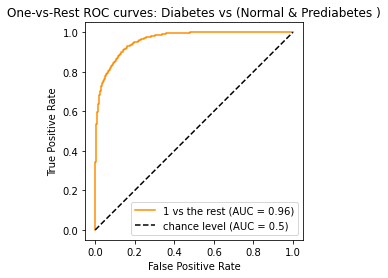

In [ ]:
RocCurveDisplay.from_predictions(
    y_onehot_test[:, 2],
    y_score[:, 2],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: Diabetes vs (Normal & Prediabetes )")
plt.legend()
plt.show()

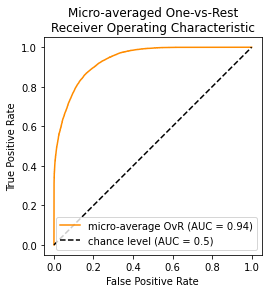

In [ ]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.94


In [ ]:
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.91


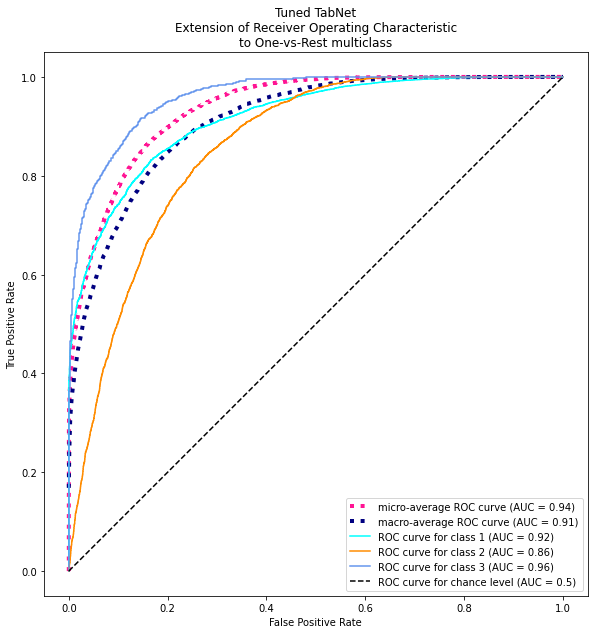

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Tuned TabNet\nExtension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
joblib.dump(tab3, 'tunedtabnet.joblib')

['tunedtabnet.joblib']